In [3]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/metric_fam_novel'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [5]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [6]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'

In [7]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [8]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [6]:
# skip if just loading
best_n_all_ = best_n_all_test
import glob
cell_metrics_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    
    metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
    cell_metrics_df = pd.DataFrame({k:cell_metrics[k] for k in metrics})
    cell_metrics_df_all[ani,sess] = cell_metrics_df
cell_metrics_df_all = pd.concat(cell_metrics_df_all,axis=0)

cell_metrics_df_all['UID'] = cell_metrics_df_all['UID'].astype(int)
cell_metrics_df_all = cell_metrics_df_all.reset_index(level=2,drop=True).set_index('UID',append=True)

# field with any switch vs no switch, metrics
task_index=0
cell_with_any_sw_one_task = best_n_all_.loc[(slice(None),slice(None),task_index)].groupby(level=(0,1,3)).apply(lambda x:(x>0).any())
cell_metrics_df_all['has_switch']  = cell_with_any_sw_one_task

ma=cell_metrics_df_all['has_switch'].notna()
cell_metrics_df_all_pc = cell_metrics_df_all.loc[ma]

In [9]:
import variability_axis as va
reload(va)

<module 'variability_axis' from '/mnt/home/szheng/projects/place_variability/code/variability_axis.py'>

In [ ]:
# actual code for producing the per_field_metrics_all, skip if loading
per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all_test,level=(0,1,2,3),pf_params_loc_ind=2)
per_tt_neuron_metrics = va.get_per_neuron_metrics(spk_beh_df_all,fr_map_trial_df_all,fr_map_all,occu_map_all,stab_level=(0,1,2,3,4),si_level=(0,1))
per_field_metrics_all = va.assign_per_neuron_property_to_field(per_field_var_metrics,per_tt_neuron_metrics)


In [8]:
### skip if loading
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp_fixed.p')
# per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# actual code for producing the per_field_metrics_all
per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all_test,level=(0,1,2,3),pf_params_loc_ind=2)
per_tt_neuron_metrics = va.get_per_neuron_metrics(spk_beh_df_all,fr_map_trial_df_all,fr_map_all,occu_map_all,stab_level=(0,1,2,3,4),si_level=(0,1))
per_field_metrics_all = va.assign_per_neuron_property_to_field(per_field_var_metrics,per_tt_neuron_metrics)


gpb=per_field_metrics_all.groupby(level=(0,1,4),sort=False)
fr_nrem_all = []
for k,val in gpb:
    fr_nrem=np.ones(val.shape[0]) * cell_metrics_df_all.loc[k,'firingRate_NREMstate']
    fr_nrem_all.append(pd.Series(fr_nrem,index=val.index))
fr_nrem_all = pd.concat(fr_nrem_all,axis=0)
    

per_field_metrics_all['fr_nrem']=fr_nrem_all

pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may i

/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past l

In [10]:
import statsmodels.formula.api as smf

from statsmodels.stats.mediation import Mediation


In [40]:
# key='fr_cv_beh'
# data=per_field_metrics_all[[key,'fr_nrem']].unstack(level=2).dropna().iloc[:,:3]
# data.columns=['fam','nov','fr']
# outcome_model = smf.ols('nov~fam+fr',data=data)
# mediator_model = smf.ols('fr~fam',data=data)
# med=Mediation(outcome_model,mediator_model,'fam', mediator='fr').fit()
# med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.068544,0.045212,0.092862,0.0
ACME (treated),0.068544,0.045212,0.092862,0.0
ADE (control),0.201405,0.140300,0.263876,0.0
ADE (treated),0.201405,0.140300,0.263876,0.0
Total effect,0.269949,0.210185,0.331214,0.0
Prop. mediated (control),0.252973,0.167654,0.360217,0.0
Prop. mediated (treated),0.252973,0.167654,0.360217,0.0
ACME (average),0.068544,0.045212,0.092862,0.0
ADE (average),0.201405,0.140300,0.263876,0.0
Prop. mediated (average),0.252973,0.167654,0.360217,0.0


In [11]:
import copy
def resid_regression(data,confound_exog,exog,endog,regress_out_exog=False):
    data=copy.copy(data)
    formula=endog+'~'+'+'.join(confound_exog)
    regress_out_confound_res = smf.ols(formula,data=data).fit()
    resid = regress_out_confound_res.resid
    data['resid'] = resid
    if regress_out_exog:
        formula=exog[0]+'~'+'+'.join(confound_exog)
        regress_out_confound_exog_res = smf.ols(formula,data=data).fit()
        data[exog[0]]=regress_out_confound_exog_res.resid
        
    formula = endog+'~'+'+'.join(exog)
    res = smf.ols(formula,data=data).fit()
    if regress_out_exog:
        return res,regress_out_confound_res,regress_out_confound_exog_res
    else:
        return res,regress_out_confound_res

In [12]:
def print_reg_result(res):
    
    print(f'r2: {res.rsquared:3g}')
    print(f'F-stat: {res.fvalue:3g}', )
    print(f'F, p-value: {res.f_pvalue:3g}', )
    print('Dependent Var:',res.model.endog_names)
    
#     pd.set_option('display.float_format', '{:3g}'.format)
    df=res.summary2().tables[1].iloc[1:]
#     df.style.format("{:3g}")
    print(df)
    print('\n')
    

In [13]:
per_field_metrics_all['fr_nrem_log'] = np.log(per_field_metrics_all['fr_nrem'])

In [18]:
data=per_field_metrics_all[['fit_var_ratio_1cp','fr_nrem_log']].unstack(level=2).dropna().iloc[:,:3]
data.shape

(955, 3)

In [24]:
np.set_printoptions(precision=3)
fr_key = 'fr_nrem_log' # 'fr_nrem' #
for key in ['fr_cv_beh','lap_correlation','fit_var_ratio_1cp']:
# key='fit_var_ratio_1cp'#'lap_correlation'#'fr_cv_beh'#
    data=per_field_metrics_all[[key,fr_key]].unstack(level=2).dropna().iloc[:,:3]
    data.columns=['fam','nov','fr']

    confound_exog=['fr']      
    exog = ['fam']
    endog= 'nov'
    # res,regress_out_confound_res = resid_regression(data,confound_exog,exog,endog)
    res,regress_out_confound_res,regress_out_confound_exog_res = resid_regression(data,confound_exog,exog,endog,regress_out_exog=True)
    
    print(key)
    print(f'===regress {key} on FR ===\n')
    print_reg_result(regress_out_confound_exog_res)
    print_reg_result(regress_out_confound_res)
    print(f'==={key} residual regression===\n')
    print_reg_result(res)
    print('======END=======\n\n')

fr_cv_beh
===regress fr_cv_beh on FR ===

r2: 0.115183
F-stat: 124.059
F, p-value: 3.57928e-27
Dependent Var: fam
       Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
fr -0.191904  0.017229 -11.13818  3.579282e-27 -0.225716 -0.158092


r2: 0.141907
F-stat: 157.602
F, p-value: 1.45466e-33
Dependent Var: nov
       Coef.  Std.Err.          t         P>|t|    [0.025    0.975]
fr -0.211062  0.016812 -12.553958  1.454661e-33 -0.244056 -0.178069


===fr_cv_beh residual regression===

r2: 0.0238894
F-stat: 23.3238
F, p-value: 1.59418e-06
Dependent Var: nov
        Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
fam  0.162815  0.033713  4.829473  0.000002  0.096655  0.228975


======END=======


lap_correlation
===regress lap_correlation on FR ===

r2: 0.000753675
F-stat: 0.718794
F, p-value: 0.396753
Dependent Var: fam
     Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
fr -0.0096  0.011323 -0.847817  0.396753 -0.031822  0.012621


r2: 0.0134664
F-stat: 13.0087


In [185]:
# data=per_field_metrics_all[[key,'fr_nrem']].unstack(level=2).dropna().iloc[:,:3]
# data.columns=['fam','nov','fr']

In [66]:
# key='fr_cv_beh'#
# data=per_field_metrics_all[[key,'fr_nrem']].unstack(level=2).dropna().iloc[:,:3]
# data.columns=['fam','nov','fr']

# confound_exog=['fr']               
# exog = ['fam']
# endog= 'nov'
# res,regress_out_confound_res = resid_regression(data,confound_exog,exog,endog)
# res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nov   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     76.89
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           8.19e-18
Time:                        15:17:52   Log-Likelihood:                -439.24
No. Observations:                 955   AIC:                             882.5
Df Residuals:                     953   BIC:                             892.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5714      0.024     24.231      0.000       0.525       0.618
fam            0.2707      0.031      8.769      0.000       0.210       0.331
==============================================================================
Omnibus:                      260.055   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.963
Skew:                           1.399   Prob(JB):                    1.50e-150
Kurtosis:                       6.084   Cond. No.                         3.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# key='fit_var_ratio_1cp'#
# data=per_field_metrics_all[[key,'fr_nrem']].unstack(level=2).dropna().iloc[:,:3]
# data.columns=['fam','nov','fr']

# confound_exog=['fr']               
# exog = ['fam']
# endog= 'nov'
# res,regress_out_confound_res = resid_regression(data,confound_exog,exog,endog)
# res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nov   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7701
Date:                Mon, 11 Sep 2023   Prob (F-statistic):              0.380
Time:                        15:18:06   Log-Likelihood:                 158.66
No. Observations:                 955   AIC:                            -313.3
Df Residuals:                     953   BIC:                            -303.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3251      0.013     25.126      0.000       0.300       0.350
fam            0.0278      0.032      0.878      0.380      -0.034       0.090
==============================================================================
Omnibus:                       88.648   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.935
Skew:                           0.841   Prob(JB):                     3.00e-25
Kurtosis:                       3.093   Cond. No.                         5.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# key='lap_correlation'#'fr_cv_beh'
# data=per_field_metrics_all[[key,'fr_nrem']].unstack(level=2).dropna().iloc[:,:3]
# data.columns=['fam','nov','fr']
# outcome_model = smf.ols('nov~fam+fr',data=data)
# mediator_model = smf.ols('fr~fam',data=data)
# med=Mediation(outcome_model,mediator_model,'fam', mediator='fr').fit()
# med.summary()

In [35]:
data[['fam','nov']].max().max()

0.9912235039296347

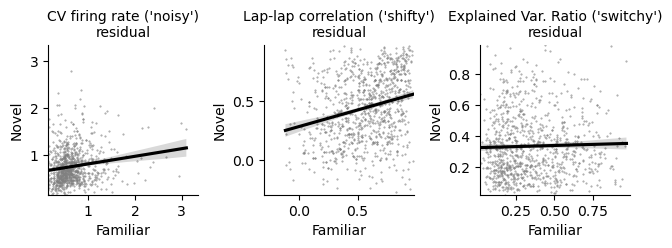

In [38]:
import matplotlib.colors as mcolors

# sns.set(rc = {'figure.figsize':(20,8)})
# sns.reset_defaults()
# plt.rcParams['svg.fonttype']='none'
# current_rc_params = plt.rcParams.copy()
# Set the font scale (font size) you want to use
# font_scale = 0.8
# plt.rcParams.update({'font.size': current_rc_params['font.size'] * font_scale})

fig,axs=plt.subplots(1,3,figsize=(6.5,2.5))
fr_key = 'fr_nrem_log' # 'fr_nrem' #

key_title_d = {'fr_cv_beh':"CV firing rate ('noisy')\nresidual",'lap_correlation':"Lap-lap correlation ('shifty')\nresidual",'fit_var_ratio_1cp':"Explained Var. Ratio ('switchy')\nresidual"}
for ii,key in enumerate(['fr_cv_beh','lap_correlation','fit_var_ratio_1cp']):
    ax=axs[ii]
    ax.set_aspect('equal')
    data=per_field_metrics_all[[key,fr_key]].unstack(level=2).dropna().iloc[:,:3]
    data.columns=['fam','nov','fr']

    norm = mcolors.Normalize()
    c_l=plt.colormaps['Spectral'](norm(data['fr']))

    # cmap='Spectral'
    # scatter_kws={'norm':norm,'cmap':cmap,'color':data['fr']}
#     scatter_kws={'c':c_l,'cmap':'Spectral','color':None,'s':1.}
    scatter_kws={'s':0.2,'color':'Grey'}
#     fig,ax=plt.subplots(figsize=(1,1))
    xx=sns.regplot(data=data,x='fam',y='nov',color='k',scatter_kws=scatter_kws,ax=ax,y_partial='fr',x_partial='fr')
    ax.set_title(key)
    sns.despine()
    ax.set(xlabel='Familiar',ylabel='Novel',title=key_title_d[key])
    axis_min = data[['fam','nov']].min().min() 
    axis_max = data[['fam','nov']].max().max() 
    ax.set_xlim([axis_min,axis_max])
    ax.set_ylim([axis_min,axis_max])
    # plt.colorbar(xx._children[0],cmap='Spectral')
plt.tight_layout()
figfn = 'metric_resid_logfr_nov_vs_fam'
ph.save_given_name(fig,figfn,figdir,dpi=900)
#     fig.savefig(os.path.join(figdir,f'{key}_resid_nov_vs_fam.svg'),bbox_inches='tight')
#     fig.savefig(os.path.join(figdir,f'{key}_resid_nov_vs_fam.png'),bbox_inches='tight')

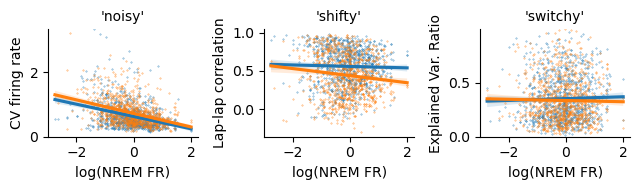

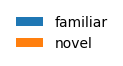

In [39]:
import matplotlib.colors as mcolors
key_title_d={'fr_cv_beh':"'noisy'",'lap_correlation':"'shifty'",'fit_var_ratio_1cp':"'switchy'"}
key_label_d = {'fr_cv_beh':"CV firing rate",'lap_correlation':"Lap-lap correlation",'fit_var_ratio_1cp':"Explained Var. Ratio"}

fr_key = 'fr_nrem_log' # 'fr_nrem' #
fig,axs=plt.subplots(1,3,figsize=(6.5,2))
for ii,key in enumerate(['fr_cv_beh','lap_correlation','fit_var_ratio_1cp']):
    ax=axs[ii]
    key_title=key_title_d[key]
    key_label=key_label_d[key]
    data=per_field_metrics_all[[key,fr_key]].unstack(level=2).dropna().iloc[:,:3]
    data.columns=['fam','nov','fr']

    norm = mcolors.Normalize()
    c_l=plt.colormaps['Spectral'](norm(data['fr']))

    # cmap='Spectral'
    # scatter_kws={'norm':norm,'cmap':cmap,'color':data['fr']}
#     scatter_kws={'c':c_l,'cmap':'Spectral','color':None,'s':1.}
    scatter_kws={'s':.1}
#     fig,ax=plt.subplots(figsize=(1,1))
    xx=sns.regplot(data=data,x='fr',y='fam',color=None,scatter_kws=scatter_kws,ax=ax,label='familiar')
    xx=sns.regplot(data=data,x='fr',y='nov',color=None,scatter_kws=scatter_kws,ax=ax,label='novel')
    ax.set_title(key_title)
    ax.set(ylabel=key_label,xlabel='log(NREM FR)')
    if data[['fam','nov']].min().min()>0:
        ymax=data[['fam','nov']].max().max()
        ax.set_ylim([0,ymax])

    sns.despine()
#     plt.legend(bbox_to_anchor=[1.05,1])
plt.tight_layout()

figfn = 'metric_vs_logfr'
ph.save_given_name(fig,figfn,figdir,dpi=900)

reload(ph)
fig,ax=ph.plot_legend(labels=['familiar','novel'])
figfn = figfn + '_legend'
ph.save_given_name(fig,figfn,figdir)
    
#     fig.savefig(os.path.join(figdir,f'{key}_vs_fr.svg'),bbox_inches='tight')
#     fig.savefig(os.path.join(figdir,f'{key}_vs_fr.png'),bbox_inches='tight')
    
    # plt.colorbar(xx._children[0],cmap='Spectral')

# examples

In [273]:
best_n_all_test.groupby(level=(0,1,2)).apply(lambda x:(x>0).mean())

e13_16f1  e13_16f1_210302  0    0.212963
          e13_16f1_210312  0    0.152838
          e13_16f1_210314  0    0.155462
          e13_16f1_210317  0    0.115226
          e13_16f1_210319  0    0.161765
          e13_16f1_210322  0    0.206897
          e13_16f1_210328  0    0.167442
          e13_16f1_210331  0    0.124324
e13_26m1  e13_26m1_210913  0     0.39878
          e13_26m1_211019  0    0.284444
                           1    0.335211
          e13_26m1_211116  0    0.148485
                           1    0.299145
          e13_26m1_211119  0     0.23053
                           1         0.5
          e13_26m1_211124  0    0.241259
e14_2m2   e14_2m2_201017   0    0.186813
          e14_2m2_201019   0    0.138528
e14_2m3   e14_2m3_201118   0    0.190909
          e14_2m3_201121   0    0.102564
          e14_2m3_201125   0    0.114943
          e14_2m3_201129   0    0.164384
          e14_2m3_201206   0    0.169811
          e14_2m3_201208   0    0.215686
e15_10m1  e15_10

In [15]:
ani='e15_13f1'#'e13_26m1'
sess='e15_13f1_220119'#'e13_26m1_211019'
fr_map_trial_df_one = fr_map_trial_df_all.loc[ani,sess]
all_sw_with_metrics_one = all_sw_with_metrics_d_all.loc[ani,sess]

/tmp/ipykernel_62484/985944410.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_one = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_62484/985944410.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics_one = all_sw_with_metrics_d_all.loc[ani,sess]


In [16]:
per_field_metrics_one = per_field_metrics_all.loc[ani,sess]

/tmp/ipykernel_62484/787872172.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[ani,sess]


In [17]:
per_neuron_metrics_one = per_field_metrics_one.groupby(level=(0,2)).max()
per_neuron_metrics_one_unstack = per_neuron_metrics_one.unstack(level=0)

In [123]:
per_neuron_metrics_one_unstack['si'].min(axis=1)

42     0.191580
43     0.445240
47     0.394121
48     0.048846
51     0.329323
         ...   
295    1.650253
297    2.714403
298    0.854850
299    2.285805
302    0.738011
Length: 219, dtype: float64

# select fam switch novel no switch

In [176]:
si_thresh = 0.5
# ma = ((per_neuron_metrics_one_unstack['si'] > si_thresh).all(axis=1)) &  \
#         (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][0] > 0.5)& \
#         (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][1] < 0.3 )

ma =    (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][0] > 0.6)& \
        (per_neuron_metrics_one_unstack['fit_var_ratio'][1] < 0.2) & (per_neuron_metrics_one_unstack['si'].min(axis=1) > si_thresh)
#         (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][1] < 0.4)



# ma =    (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][0] < 0.4)& \
#         (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][1] > 0.8)




In [44]:
# ind_l=all_sw_with_metrics_one.loc[0].query('switch==1&switch_trial_frac>0.7')[['trialtype','uid','field_index']]

<Axes: xlabel='0', ylabel='1'>

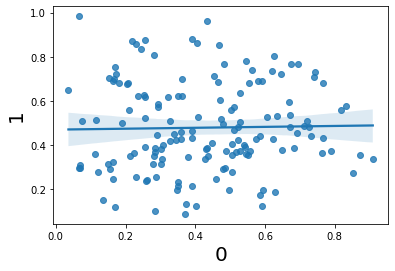

In [63]:
sns.regplot(x=per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][0],y=per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][1])




In [172]:
# ma=(per_neuron_metrics_one_unstack['si'] > si_thresh).all(axis=1)

In [242]:
# adjust the number here and inspect the plot later, then record the best uid
uid=per_neuron_metrics_one_unstack.loc[ma]['fit_var_ratio_1cp'].index[9]
# uid=ind_l['uid'].iloc[5]

In [234]:
per_neuron_metrics_one_unstack.loc[ma]['fit_var_ratio_1cp']

,0,1
55,0.804505,0.528885
74,0.700079,0.397134
91,0.720157,0.384492
97,0.621915,0.232909
112,0.717233,0.609747
114,0.896118,0.318767
121,0.829637,0.352963
123,0.866809,0.298684
134,0.634188,0.502458
138,0.627302,0.278032


In [243]:
argmax_tt_per_ti=per_field_metrics_one.loc[(slice(None),slice(None),uid),:].groupby(level=0)['fit_var_ratio_1cp'].idxmax()
argmax_tt_per_ti


0    (0, 0.0, 138, 0)
1    (1, 0.0, 138, 0)
Name: fit_var_ratio_1cp, dtype: object

/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


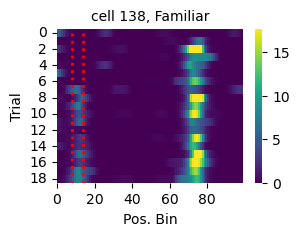

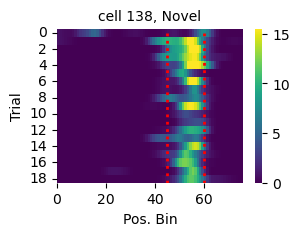

In [280]:
task_d = {0:'Familiar',1:'Novel'}
for ti in [0,1]:
    task =task_d[ti]
    ind=argmax_tt_per_ti.loc[ti]
    _,tt,uid,field_id=ind
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
    frmap = fr_map_trial_df_one.loc[(ti,tt_rm,uid),:].dropna(axis=1,how='all').T
    fig,ax=ph.ratemap_one_raw(frmap,field_bound=field_bound,heatmap_kws={})
    ax.set_title(f'cell {uid}, {task}')
    ax.set(xlabel='Pos. Bin',ylabel='Trial')
#     fig.savefig(os.path.join(figdir,f'ex_fam_{sess}_{ind}.svg'),bbox_inches='tight')
#     fig.savefig(os.path.join(figdir,f'ex_fam_{sess}_{ind}.png'),bbox_inches='tight')

# select nov switch fam no switch

In [281]:
si_thresh = 0.5
ma =    (per_neuron_metrics_one_unstack['fit_var_ratio_1cp'][1] > 0.6)& \
        (per_neuron_metrics_one_unstack['fit_var_ratio'][0] < 0.2) & (per_neuron_metrics_one_unstack['si'].min(axis=1) > si_thresh)


In [282]:
per_neuron_metrics_one_unstack.loc[ma]['fit_var_ratio_1cp']

,0,1
84,0.395891,0.631187
110,0.357772,0.661211
111,0.246280,0.653665
113,0.218191,0.641566
136,0.067264,0.723078
144,0.514630,0.625869
159,0.440171,0.682224
174,0.150097,0.898307
205,0.459556,0.685821
270,0.262888,0.675300


In [334]:
# adjust the number here and inspect the plot later, then record the best uid
uid=per_neuron_metrics_one_unstack.loc[ma]['fit_var_ratio_1cp'].index[4]
# uid=ind_l['uid'].iloc[5]

In [337]:
argmax_tt_per_ti=per_field_metrics_one.loc[(slice(None),slice(None),uid),:].groupby(level=0)['fit_var_ratio_1cp'].idxmax()
argmax_tt_per_ti


0    (0, 0.0, 136, 0)
1    (1, 0.0, 136, 1)
Name: fit_var_ratio_1cp, dtype: object

/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


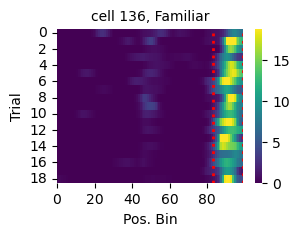

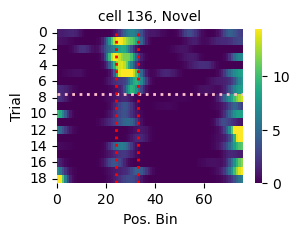

In [336]:
task_d = {0:'Familiar',1:'Novel'}
for ti in [0,1]:
    task =task_d[ti]
    ind=argmax_tt_per_ti.loc[ti]
    _,tt,uid,field_id=ind
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    try:
        ind_within=all_sw_d_all.set_index(['trialtype','uid','field_index'],append=True).loc[ani,sess,ti,slice(None),tt,uid,field_id]['index_within'].iloc[0]

    except:
        ind_within=None
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
    frmap = fr_map_trial_df_one.loc[(ti,tt_rm,uid),:].dropna(axis=1,how='all').T
    fig,ax=ph.ratemap_one_raw(frmap,field_bound=field_bound,heatmap_kws={},trial=ind_within)
    ax.set_title(f'cell {uid}, {task}')
    ax.set(xlabel='Pos. Bin',ylabel='Trial')
#     fig.savefig(os.path.join(figdir,f'ex_fam_{sess}_{ind}.svg'),bbox_inches='tight')
#     fig.savefig(os.path.join(figdir,f'ex_fam_{sess}_{ind}.png'),bbox_inches='tight')

In [288]:
all_sw_d_all.set_index(['trialtype','uid','field_index'],append=True).loc[ani,sess,1,slice(None),0,uid,0]['index_within'].iloc[0]



IndexError: single positional indexer is out-of-bounds

In [290]:
ani,sess

('e15_13f1', 'e15_13f1_220119')

In [247]:
argmax_tt_per_ti

0    (0, 0.0, 138, 0)
1    (1, 0.0, 138, 0)
Name: fit_var_ratio_1cp, dtype: object

In [258]:
frmap.loc[:,field_bound['start']:field_bound['end']].max().max()

18.73250016625813

In [307]:
all_fields_recombined_all.loc[ani,sess,ti,tt,uid]

/tmp/ipykernel_1611817/1024443699.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined_all.loc[ani,sess,ti,tt,uid]


,start,end,com,peak,fr_peak,fr_mean,other_field_index
field_index,,,,,,,
1,57,74,65,68,12.14919,9.106845,NaN


0.6273020487778407

/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_62484/828183805.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks,rotation=0)
/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_62484/828183805.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks,rotation=0)
/mnt/home/szheng/projects/util_code/plot_helper.py:574: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_62484/828183805.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks,rotation=0)
/mnt

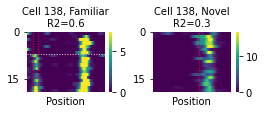

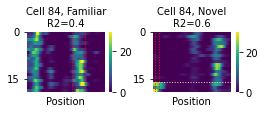

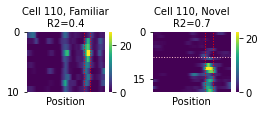

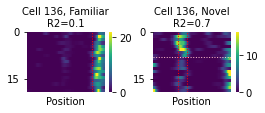

In [26]:
from matplotlib.ticker import MaxNLocator
task_d = {0:'Familiar',1:'Novel'}
ind_selected_l = [((0,0),138,(0,0)),
                  ((0,'both'),84,(1,0)),
                  ((1,0),110,(1,0)),
                  ((0,0),136,(0,1))
                  
                 ] # tt, uid, field_id
for ind_ in ind_selected_l:
    fig,axs = plt.subplots(1,2,figsize=(4,1.1))
    tt_l,uid,field_id_l = ind_
    for ti in [0,1]:
        tt = tt_l[ti]
        if tt=='both':
            tt_rm=0
        else:
            tt_rm=tt
        field_id = field_id_l[ti]
        ax=axs[ti]
        field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
        frmap = fr_map_trial_df_one.loc[(ti,tt_rm,uid),:].dropna(axis=1,how='all').T
        try:
            ind_within=all_sw_d_all.set_index(['trialtype','uid','field_index'],append=True).loc[ani,sess,ti,slice(None),tt,uid,field_id]['index_within'].iloc[0]
            
        except:
            ind_within=None
            
        vmax=frmap.loc[:,field_bound['start']:field_bound['end']].max().max()*0.9
            
        
        fig,ax=ph.ratemap_one_raw(frmap,field_bound=field_bound,fig=fig,ax=ax,trial=ind_within,line_kws={'linewidth':1},heatmap_kws={'vmax':vmax})
        
        r2 = per_field_metrics_one.loc[ti,tt,uid,field_id]['fit_var_ratio_1cp']
        
        task =task_d[ti]
        ax.set_title(f'Cell {uid}, {task}\nR2={r2:.1f}')
        ax.set(xlabel='Position',ylabel='Trial')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
        yticks=np.array(ax.get_yticks(),dtype=int)
        ax.set_yticklabels(yticks,rotation=0)
        ax.set_xticks([])
        ax.set_ylabel('')
#     axs[0].set_ylabel('Trial')
    plt.subplots_adjust(wspace=0.3)
    figfn = f'ex_{sess}_{tt_l}_{uid}_{field_id_l}'
    ph.save_given_name(fig,figfn,figdir)
#     plt.tight_layout()


In [100]:
X_raw_all_norm = X_raw_all / X_raw_all.max(axis=1).values[:,None]

In [114]:
gpb=X_raw_all_norm.groupby(level=(0,1,2,3),sort=False)
on_thresh = 0.2
for k,val in gpb:
    whether_on=val.dropna(axis=1,how='all') > on_thresh

In [130]:
min_trialwithin_on = X_raw_all_norm.apply(lambda x:np.min(np.nonzero(x.dropna().values>on_thresh)[0]),axis=1)

In [139]:
min_trialwithin_on_per_neuron=min_trialwithin_on.groupby(level=(0,1,2,4)).min()
min_trialwithin_on_per_neuron_unstack=min_trialwithin_on_per_neuron.unstack(level=2).dropna()

<Axes: xlabel='0', ylabel='1'>

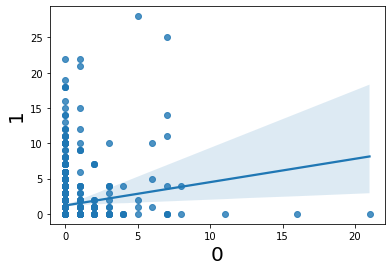

In [143]:
sns.regplot(x=min_trialwithin_on_per_neuron_unstack[0].astype(float),y=min_trialwithin_on_per_neuron_unstack[1].astype(float))



In [148]:
scipy.stats.chisquare(min_trialwithin_on_per_neuron_unstack > 0)

Power_divergenceResult(statistic=array([833., 649.]), pvalue=array([0.99734469, 1.        ]))

In [129]:
X_raw_all_norm.iloc[0].dropna().values

array([0.40249855, 0.96784631, 0.38441758, 0.        , 0.15764165,
       0.        , 0.        , 0.        , 0.        , 0.32639435,
       0.51104745, 0.11166737, 0.        , 0.        , 0.21461728,
       0.48979873, 1.        , 0.66737463, 0.99443665, 0.66836683,
       0.66946514, 0.76744953, 0.7218856 , 0.37618849, 0.36075114,
       0.48340555, 0.64844525, 0.56583749, 0.62453396, 0.5978081 ,
       0.67050324, 0.49974073, 0.63300789])

In [127]:
(min_trialwithin_on > 0).sum()

1276

In [120]:
whether_on

0      1      2      3      4      5   \
e14_2m3 e14_2m3_201118 0 both 3  0  False  False   True   True   True   True   
                              5  0   True  False   True   True   True   True   
                              6  0  False  False   True   True   True   True   
                              19 0  False  False   True   True   True   True   
                              22 0  False  False   True   True   True   True   
                              23 0  False  False   True   True   True   True   
                              24 0  False  False  False  False  False  False   
                              26 0  False   True   True   True  False   True   
                              27 0  False  False   True   True   True   True   
                              28 0  False  False   True  False   True   True   
                              30 0   True   True   True   True   True   True   
                              32 0  False  False   True   True   True   True   
                              38 0  False  False   True   True   True   True   
                              47 0  False   True   True   True  False   True   
                              53 0   True  False   True   True   True   True   

                                       6      7      8      9   ...     14  \
e14_2m3 e14_2m3_201118 0 both 3  0   True   True   True   True  ...   True   
                              5  0   True   True   True   True  ...   True   
                              6  0   True   True   True   True  ...   True   
                              19 0   True   True   True  False  ...   True   
                              22 0   True   True   True   True  ...   True   
                              23 0   True   True   True   True  ...   True   
                              24 0   True   True   True   True  ...   True   
                              26 0   True   True   True   True  ...   True   
                              27 0   True   True   True   True  ...   True   
                              28 0   True   True   True   True  ...   True   
                              30 0   True   True   True   True  ...   True   
                              32 0   True   True   True   True  ...   True   
                              38 0   True   True   True   True  ...   True   
                              47 0   True   True   True   True  ...   True   
                              53 0  False  False  False   True  ...  False   

                                       15     16     17    18     19     20  \
e14_2m3 e14_2m3_201118 0 both 3  0  False  False   True  True  False   True   
                              5  0   True  False   True  True   True   True   
                              6  0   True   True   True  True   True   True   
                              19 0   True   True   True  True   True   True   
                              22 0   True   True   True  True   True   True   
                              23 0   True   True   True  True   True   True   
                              24 0   True   True   True  True   True   True   
                              26 0   True   True   True  True   True   True   
                              27 0   True   True   True  True   True   True   
                              28 0   True   True   True  True   True   True   
                              30 0   True   True   True  True   True   True   
                              32 0   True   True   True  True   True   True   
                              38 0   True  False  False  True   True  False   
                              47 0   True  False   True  True   True   True   
                              53 0   True   True   True  True   True  False   

                                       21     22     23  
e14_2m3 e14_2m3_201118 0 both 3  0  False  False  False  
                              5  0   True   True   True  
                              6  0   True   True  False  
            

In [119]:
np.nonzero(whether_on.values)[1]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 18, 20,  0,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19,
       20, 21, 22, 23,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22,  2,  3,  4,  5,  6,  7,  8, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22,  1,  2,  3,  5,  6,  7,  8,  9, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23,  2,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22,  2,  3,  4

In [107]:
X_raw_all_norm > 0.2

0      1      2     3      4      5   \
e13_26m1 e13_26m1_210913 0 0.0  3  0  False   True  False  True  False  False   
                                27 0  False   True  False  True  False  False   
                                29 0  False   True  False  True  False  False   
                                   1  False   True  False  True  False  False   
                                   2  False   True  False  True  False  False   
...                                     ...    ...    ...   ...    ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0   True   True   True  True   True   True   
                                32 0  False  False   True  True   True   True   
                                38 0  False  False   True  True   True   True   
                                47 0  False   True   True  True  False   True   
                                53 0   True  False   True  True   True   True   

                                         6      7      8      9   ...     60  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   True  False  False  False  ...  False   
                                27 0   True  False   True  False  ...  False   
                                29 0   True  False   True  False  ...  False   
                                   1   True  False   True  False  ...  False   
                                   2   True  False   True  False  ...  False   
...                                     ...    ...    ...    ...  ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0   True   True   True   True  ...  False   
                                32 0   True   True   True   True  ...  False   
                                38 0   True   True   True   True  ...  False   
                                47 0   True   True   True   True  ...  False   
                                53 0  False  False  False   True  ...  False   

                                         61     62     63     64     65  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   True  False   True  False   True   
                                27 0   True  False   True  False   True   
                                29 0  False  False   True  False  False   
                                   1   True  False   True  False   True   
                                   2   True  False   True  False   True   
...                                     ...    ...    ...    ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  False   
                                32 0  False  False  False  False  False   
                                38 0  False  False  False  False  False   
                                47 0  False  False  False  False  False   
                                53 0  False  False  False  False  False   

                                         66     67     68     69  
e13_26m1 e13_26m1_210913 0 0.0  3  0  False  False   True  False  
                                27 0  False  False   True  False  
                                29 0  False  False  False  False  
                                   1  False  False   True  False  
                                   2  False  False   True  False  
...                                     ...    ...    ...    ...  
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  
                                32 0  False  False  False  False  
                                38 0  False  False  False  False  
                                47 0  False  False  False  False  
                                53 0  False  False  False  False  

[14438 rows x 70 columns]

<Axes: >

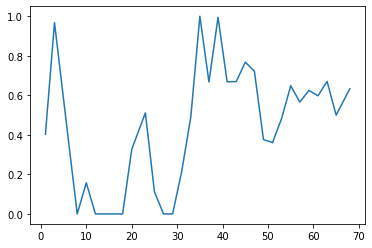

In [105]:
X_raw_all_norm.iloc[0].dropna().plot()

/tmp/ipykernel_722575/3479096385.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc_all.loc[ani,sess].loc[ind].dropna().plot()
/tmp/ipykernel_722575/3479096385.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw_all.loc[ani,sess].loc[ind].dropna().plot()


<Axes: >

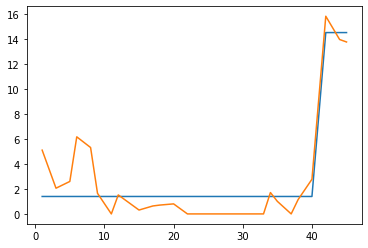

In [98]:
ind=argmax_tt_per_ti.loc[ti]
X_pwc_all.loc[ani,sess].loc[ind].dropna().plot()
X_raw_all.loc[ani,sess].loc[ind].dropna().plot()

In [389]:
si_thresh=0.6
ma = (per_neuron_metrics_one_unstack['si'] > si_thresh).all(axis=1)
per_neuron_metrics_one_unstack.loc[ma]['fit_var_ratio_1cp'].rcorr()

,0,1
0,-,
1,-0.01,-


In [346]:
ma.sum()

16

In [349]:
per_neuron_metrics_all=per_field_metrics_all.groupby(level=(0,1,2,4)).max()

per_neuron_metrics_all_unstack = per_neuron_metrics_all.unstack(level=2)

In [303]:
per_neuron_metrics_one_unstack['fit_var_ratio']

,0,1
1,1.25514e-31,0.854475
11,0.526892,7.02391e-31
18,0.515484,2.76034e-32
27,0.471155,1.31276e-30
35,0.717659,3.64653e-31
...,...,...
266,6.44556e-31,0.805427
267,1.44062e-31,0.98335
268,9.1615e-31,NaN
270,2.06187e-31,0.851144


In [291]:
per_field_metrics_one

frac_trial_active  fr_cv_beh  loc_std field_width  tot_var  \
0 0.0  11  1                  1   0.333828  6.97247          24  12.9997   
       27  0                  1   0.243437  4.03863          11  24.0287   
           1                  1   0.252748  2.82137           8  16.6519   
           3                  1   0.247037  2.39717           6  13.4735   
       35  1           0.777778   0.580226  2.04089           5  4.24848   
...                         ...        ...      ...         ...      ...   
1 both 250 0           0.666667   0.675328  5.19086          20  3.26448   
       252 0           0.787879   0.905148  4.26335          17  61.6769   
       253 0           0.484848    1.00706  3.09264           4  11.2796   
       261 0           0.666667    1.05934  3.44381          10  47.1201   
       266 0            0.30303    1.37266  2.65004           7  6.67833   

                mean     fit_var  resid2_mean  fit_var_ratio  \
0 0.0  11  1 11.0062     6.84942      6.15024       0.526892   
       27  0 20.5198 1.26218e-29      24.0287     5.2528e-31   
           1 16.4528 1.26218e-29      16.6519    7.57978e-31   
           3 15.1416 3.15544e-30      13.4735    2.34197e-31   
       35  1 3.62005     1.85599      2.39248       0.436861   
...              ...         ...          ...            ...   
1 both 250 0  2.7169           0      3.26448              0   
       252 0 8.81097     35.1067      26.5703       0.569203   
       253 0 3.38668     5.65927      5.62035       0.501725   
       261 0 6.58038           0      47.1201              0   
       266 0 1.91185           0      6.67833              0   

              resid2_mean_ratio  tot_var_norm  fit_var_norm  resid2_mean_norm  \
0 0.0  11  1           0.473108       1.18112      0.622323          0.558797   
       27  0                  1         1.171   6.15101e-31             1.171   
           1                  1        1.0121   7.67151e-31            1.0121   
           3                  1       0.88983   2.08395e-31           0.88983   
       35  1           0.563139        1.1736      0.512699          0.660898   
...                         ...           ...           ...               ...   
1 both 250 0                  1       1.20154             0           1.20154   
       252 0           0.430797       7.00002       3.98443           3.01559   
       253 0           0.498275       3.33058       1.67104           1.65955   
       261 0                  1        7.1607             0            7.1607   
       266 0                  1       3.49313             0           3.49313   

              fit_var_ratio_1cp  fit_var_ratio_div_sh_1cp  log_mean  \
0 0.0  11  1           0.526892                   4.59731   2.39846   
       27  0           0.251929                   2.11101   3.02139   
           1           0.242982                   2.02706    2.8005   
           3           0.305963                    2.5268   2.71745   
       35  1           0.436861                   3.58766   1.28649   
...                         ...                       ...       ...   
1 both 250 0            0.10239                  0.976773  0.999493   
       252 0           0.295545                   3.01207     2.176   
       253 0           0.501725                   5.12643   1.21985   
       261 0           0.149012                   1.50315   1.88409   
       266 0           0.341313                    3.5417   0.64807   

              lap_correlation        si  sparsity  fr_nrem  
0 0.0  11  1         0.524534  0.153931   1.46196  2.25905  
       27  0         0.208466 0.0103766   1.08711  1.75805  
           1         0.208466 0.0103766   1.08711  1.75805  
           3         0.208466 0.0103766   1.08711  1.75805  
       35  1          0.13522  0.115041   1.04599  2.19346  
...                       ...       ...       ...      ...  
1 both 250 0         0.115917  0.152317   1.28573  1.22077  
       252 0      

In [290]:
per_field_metrics_one.unstack(level=0)

frac_trial_active          fr_cv_beh          loc_std          \
                           0        1         0        1       0       1   
0.0  11  1                 1        1  0.333828 0.363156 6.97247 4.89022   
     27  1                 1      NaN  0.252748      NaN 2.82137     NaN   
         0                 1      NaN  0.243437      NaN 4.03863     NaN   
         3                 1      NaN  0.247037      NaN 2.39717     NaN   
     35  1          0.777778 0.666667  0.580226 0.590141 2.04089 1.80476   
...                      ...      ...       ...      ...     ...     ...   
both 268 0          0.765957      NaN  0.597886      NaN  2.6817     NaN   
     222 1               NaN 0.242424       NaN  2.12186     NaN 2.55396   
     124 0               NaN 0.242424       NaN    1.179     NaN 3.08313   
     219 0               NaN 0.151515       NaN  2.18207     NaN 1.57454   
     240 0               NaN 0.181818       NaN  2.55402     NaN 1.22706   

           field_width      tot_var          ... log_mean           \
                     0    1       0       1  ...        0        1   
0.0  11  1          24   15 12.9997 4.49243  ...  2.39846  1.78851   
     27  1           8  NaN 16.6519     NaN  ...   2.8005      NaN   
         0          11  NaN 24.0287     NaN  ...  3.02139      NaN   
         3           6  NaN 13.4735     NaN  ...  2.71745      NaN   
     35  1           5    4 4.24848 2.16332  ...  1.28649 0.937611   
...                ...  ...     ...     ...  ...      ...      ...   
both 268 0          10  NaN 5.38163     NaN  ...   1.3666      NaN   
     222 1         NaN    8     NaN 10.0327  ...      NaN 0.416015   
     124 0         NaN    8     NaN 2.53344  ...      NaN 0.315511   
     219 0         NaN    6     NaN 9.62756  ...      NaN 0.367428   
     240 0         NaN    5     NaN  43.724  ...      NaN 0.966666   

           lap_correlation                  si           sparsity           \
                         0         1         0         1        0        1   
0.0  11  1        0.524534  0.121611  0.153931 0.0577716  1.46196 0.960296   
     27  1        0.208466       NaN 0.0103766       NaN  1.08711      NaN   
         0        0.208466       NaN 0.0103766       NaN  1.08711      NaN   
         3        0.208466       NaN 0.0103766       NaN  1.08711      NaN   
     35  1         0.13522  0.232455  0.115041  0.163682  1.04599  1.42874   
...                    ...       ...       ...       ...      ...      ...   
both 268 0        0.652698       NaN   1.35315       NaN  6.29796      NaN   
     222 1             NaN   0.06939       NaN  0.493365      NaN  1.38874   
     124 0             NaN 0.0831007       NaN   0.14178      NaN  1.28985   
     219 0             NaN  0.537425       NaN   1.87401      NaN  5.80198   
     240 0             NaN  0.377578       NaN   1.51421      NaN  6.98578   

           fr_nrem            
                 0         1  
0.0  11  1 2.25905   2.25905  
     27  1 1.75805       NaN  
         0 1.75805       NaN  
         3 1.75805       NaN  
     35  1 2.19346   2.19346  
...            ...       ...  
both 268 0 1.08892       NaN  
     222 1     NaN  0.370558  
     124 0     NaN  0.890734  
     219 0     NaN   0.23904  
     240 0     NaN 0.0422617  

[642 rows x 40 columns]

In [288]:
val

,,,,frac_trial_active,fr_cv_beh,loc_std,field_width,tot_var,mean,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm,fit_var_ratio_1cp,fit_var_ratio_div_sh_1cp,log_mean,lap_correlation,si,sparsity,fr_nrem
0,0.0,271,0,1,0.275166,1.4676,11,2.11062,5.38029,3.15544e-30,2.11062,1.49503e-30,1,0.392288,5.86482e-31,0.392288,0.0983655,0.829659,1.68274,0.917354,2.19143,9.81657,0.253487


In [281]:
ma = (all_sw_with_metrics_one['pre_mean_fr_3_norm'] < 0.2)

0  0      False
   1      False
   2      False
   3      False
   4      False
          ...  
1  167    False
   168    False
   169    False
   170    False
   171    False
Name: pre_mean_fr_3_norm, Length: 341, dtype: bool

In [282]:
all_sw_with_metrics_one

trialtype  uid  field_index    time  speed_gauss  field_pos  \
0 0        both   67            0 7710.24      43.7236         18   
  1        both   86            0 7708.48      2.05487          5   
  2           1   41            0 7802.85      30.6587         18   
  3           1   51            1 7816.85      12.5688         77   
  4           1   59            0 7817.24      13.6835         79   
...         ...  ...          ...     ...          ...        ...   
1 167         0  198            0 16599.9      21.9576         49   
  168         0  262            0 16560.9        2.549          0   
  169         0  266            1 16605.7      2.80328         67   
  170      both  240            0 16560.9        2.549          0   
  171      both  222            1 16648.9      9.77525         13   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2       1             1             2  ...   
  1              2       1             1             2  ...   
  2              4      -1             2             2  ...   
  3              4       1             2             2  ...   
  4              4       1             2             2  ...   
...            ...     ...           ...           ...  ...   
1 167           30       1            19            19  ...   
  168           30      -1            19            19  ...   
  169           30      -1            19            19  ...   
  170           30      -1            19            30  ...   
  171           31       1            11            31  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                    0                          0.0212766   
  1                                    0                          0.0212766   
  2                                    0                                  0   
  3                                    0                                  0   
  4                                    0                                  0   
...                                  ...                                ...   
1 167                                  0                                  0   
  168                                  0                           0.047619   
  169                                  0                           0.047619   
  170                                  0                          0.0606061   
  171                                  0                                  0   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.12766                           0.404255   
  1                            0.0638298                            0.12766   
  2                                  0.2                                0.2   
  3                                 0.15                                0.4   
  4                                 0.05                                0.4   
...                                  ...                                ...   
1 167                                  0                                  0   
  168                          0.0952381                          0.0952381   
  169                           0.047619                          0.0952381   
  170                          0.0909091                          0.0909091   
  171                           0.030303                           0.030303   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                             0.659574                           0.744681   
  1                             0.170213                           0.191489   
  2                                  0.2                                0.2   
  3                                 0.65                               0.75   
  4                                 0.75                                0.8   
...                                  ...        

/tmp/ipykernel_1244227/317621464.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics_one = all_sw_with_metrics_d_all.loc[ani,sess]


In [ ]:
media